In [1]:
!pip install segmentation_models_pytorch wandb dataset pytorch_lightning torchsummary torchviz kaggle kagglehub pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 3.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:0000:0100:01
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=5a70376044176ca3870f6fbf2f74106d5fe054b48bf515cf1c0aca95267432c8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=06ccd3313ab9437b0024b33809507578b6e2f81f8616321b40b8a572205c2354
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built pretrainedmodels efficientnet-pytorch
  Attempting uninstall: sqlalchemy
    Fou

In [2]:
import os
import torch
import numpy as np
import random
import glob
import h5py
import yaml
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer  # Import Trainer here
import torchmetrics
import segmentation_models_pytorch as smp
import wandb

/home/hks/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set CUDA settings
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.set_float32_matmul_precision('high')

# Load the configuration file
config = """
model_config:
  model_type: "deeplabv3+"
  in_channels: 14
  num_classes: 1
  encoder_weights: "imagenet"
  wce_weight: 0.5

dataset_config:
  num_classes: 1
  num_channels: 14
  channels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12, 13, 14]
  normalize: False

train_config:
  dataset_path: "/kaggle/input/landslide4sense/TrainData"
  checkpoint_path: "checkpoints"
  seed: 42
  train_val_split: 0.8
  batch_size: 16
  num_epochs: 100
  lr: 0.001
  device: "cuda:0"
  save_config: True
  experiment_name: "deeplabv3+"

logging_config:
  wandb_project: "Land4Sense"
  wandb_entity: "Silvamillion"
"""

config = yaml.safe_load(config)
# Set the random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Utils
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    set_seed(42 + worker_id)

# Dataset
class DatasetLandslide(Dataset):
    def __init__(self, path):
        self.train_paths, self.mask_paths = self.read_data(path)

    def read_data(self, path):
        TRAIN_PATH = f"{path}/img/*.h5"
        TRAIN_MASK = f'{path}/mask/*.h5'
        all_train = sorted(glob.glob(TRAIN_PATH))
        all_mask = sorted(glob.glob(TRAIN_MASK))
        return all_train, all_mask

    def __len__(self):
        return len(self.train_paths)

    def __getitem__(self, idx):
        channels = config["dataset_config"]["channels"]
        TRAIN_XX = np.zeros((128, 128, len(channels)))

        with h5py.File(self.train_paths[idx]) as hdf:
            data = np.array(hdf.get('img'))
            data[np.isnan(data)] = 0.000001

            for i, channel in enumerate(channels):
                TRAIN_XX[:, :, i] = data[:, :, channel-1]  # Change here to use 0-based indexing
                if self.train_paths[idx].find("image") != -1:
                    TRAIN_XX[:, :, i] = data[:, :, channel-1]

            img = TRAIN_XX.transpose((2, 0, 1))  # Transponemos para tener (C, H, W)
            if config["dataset_config"]["normalize"]:
                img = (img - np.min(img)) / (np.max(img) - np.min(img))

        mask = np.array([])
        if self.mask_paths != []:
            with h5py.File(self.mask_paths[idx]) as hdf:
                mask = np.array(hdf.get('mask'))
                mask = mask[np.newaxis, :]  # Añadir dimensión de canal

        return torch.from_numpy(img).float(), torch.from_numpy(mask).float()  # Convertimos a tensores de PyTorch

In [4]:
# Model
class smp_model(nn.Module):
    def __init__(self, in_channels, out_channels, model_type, num_classes, encoder_weights):
        super(smp_model, self).__init__()
        if model_type == "deeplabv3+":
            self.model = smp.DeepLabV3Plus(
                encoder_name="resnet50",  # Change this to a valid encoder
                encoder_weights=encoder_weights,
                in_channels=in_channels,
                classes=num_classes
            )
        elif model_type == "unet":
            self.model = smp.Unet(
                encoder_name="resnet50",
                encoder_weights=encoder_weights,
                in_channels=in_channels,
                classes=num_classes,
            )
        else:
            raise ValueError(f"Model type {model_type} not supported!")

    def forward(self, x):
        return self.model(x)

class LandslideModel(pl.LightningModule):
    def __init__(self, alpha=0.5):
        super(LandslideModel, self).__init__()

        model_type = config['model_config']['model_type']
        in_channels = config['model_config']['in_channels']
        num_classes = config['model_config']['num_classes']
        self.alpha = alpha  # Assign the alpha value to the class variable
        self.lr = config['train_config']['lr']

        if model_type == 'unet':
            self.model = UNet(in_channels=in_channels, out_channels=num_classes)
        else:
            encoder_weights = config['model_config']['encoder_weights']
            self.model = smp_model(in_channels=in_channels, 
                                   out_channels=num_classes, 
                                   model_type=model_type, 
                                   num_classes=num_classes, 
                                   encoder_weights=encoder_weights)

        self.weights = torch.tensor([5], dtype=torch.float32).to(self.device)
        self.wce = nn.BCELoss(weight=self.weights)

        self.train_f1 = torchmetrics.F1Score(task='binary')
        self.val_f1 = torchmetrics.F1Score(task='binary')

        self.train_precision = torchmetrics.Precision(task='binary')
        self.val_precision = torchmetrics.Precision(task='binary')

        self.train_recall = torchmetrics.Recall(task='binary')
        self.val_recall = torchmetrics.Recall(task='binary')

        self.train_iou = torchmetrics.JaccardIndex(task='binary')
        self.val_iou = torchmetrics.JaccardIndex(task='binary')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = torch.sigmoid(self(x))

        wce_loss = self.wce(y_hat, y)
        dice = dice_loss(y_hat, y)

        combined_loss = (1 - self.alpha) * wce_loss + self.alpha * dice

        precision = self.train_precision(y_hat, y)
        recall = self.train_recall(y_hat, y)
        iou = self.train_iou(y_hat, y)
        loss_f1 = self.train_f1(y_hat, y)

        self.log('train_precision', precision)
        self.log('train_recall', recall)
        self.log('train_wce', wce_loss)
        self.log('train_dice', dice)
        self.log('train_iou', iou)
        self.log('train_f1', loss_f1)
        self.log('train_loss', combined_loss)
        return {'loss': combined_loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = torch.sigmoid(self(x))

        wce_loss = self.wce(y_hat, y)
        dice = dice_loss(y_hat, y)

        combined_loss = (1 - self.alpha) * wce_loss + self.alpha * dice

        precision = self.val_precision(y_hat, y)
        recall = self.val_recall(y_hat, y)
        iou = self.val_iou(y_hat, y)
        loss_f1 = self.val_f1(y_hat, y)

        self.log('val_precision', precision)
        self.log('val_recall', recall)
        self.log('val_wce', wce_loss)
        self.log('val_dice', dice)
        self.log('val_iou', iou)
        self.log('val_f1', loss_f1)
        self.log('val_loss', combined_loss)

        if self.current_epoch % 10 == 0:
            x = (x - x.min()) / (x.max() - x.min())
            x = x[:, 0:3]
            x = x.permute(0, 2, 3, 1)
            y_hat = (y_hat > 0.5).float()

            class_labels = {0: "no landslide", 1: "landslide"}  # Define class_labels here

            self.logger.experiment.log({
                "image": wandb.Image(x[0].cpu().detach().numpy(), masks={ 
                    "predictions": {
                        "mask_data": y_hat[0][0].cpu().detach().numpy(),
                        "class_labels": class_labels
                    },
                    "ground_truth": {
                        "mask_data": y[0][0].cpu().detach().numpy(),
                        "class_labels": class_labels
                    }
                })
            })
        return {'val_loss': combined_loss}

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
        return [optimizer], [scheduler]

class Block(nn.Module):
    def __init__(self, inputs=3, middles=64, outs=64):
        super().__init__()

        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(outs)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))
        return self.pool(x), x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.en1 = Block(in_channels, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)

        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.de4 = Block(1024, 512, 256)

        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.de3 = Block(512, 256, 128)

        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.de2 = Block(256, 128, 64)

        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.de1 = Block(128, 64, 64)

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x, e1 = self.en1(x)
        x, e2 = self.en2(x)
        x, e3 = self.en3(x)
        x, e4 = self.en4(x)
        _, x = self.en5(x)

        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        _, x = self.de4(x)

        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        _, x = self.de3(x)

        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        _, x = self.de2(x)

        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        _, x = self.de1(x)

        x = self.conv_last(x)

        return x

def dice_loss(y_hat, y):
    smooth = 1e-6
    y_hat = y_hat.view(-1)
    y = y.view(-1)
    intersection = (y_hat * y).sum()
    union = y_hat.sum() + y.sum()
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice

Using device: cuda


/tmp/ipykernel_88073/1941494101.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


No images loaded. Check the dataset path or file structure.


IndexError: list index out of range

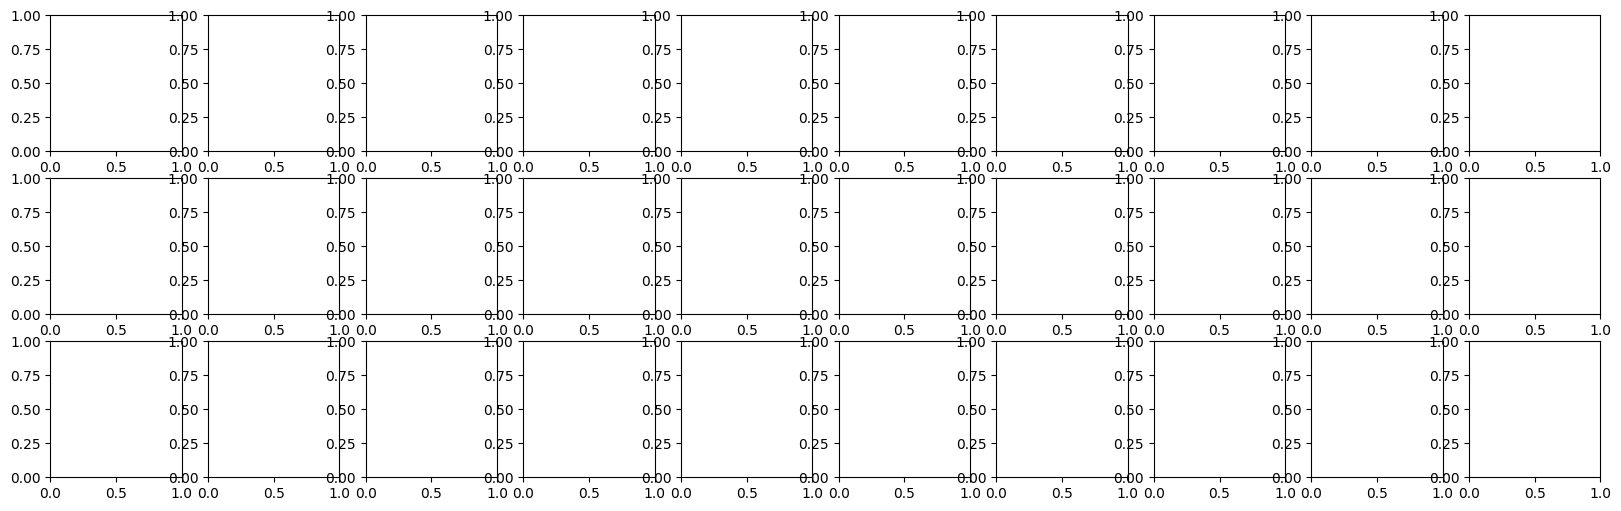

In [5]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming `DatasetLandslide` and `LandslideModel` are defined in the train script

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_path = "/home/hks/MOU/DeepLabV3+/final_model.pth"

# Initialize the model architecture and load weights
model = LandslideModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Prepare the dataset and DataLoader
data_path = "/kaggle/input/landslide4sense/TrainData"
dataset = DatasetLandslide(data_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Prepare to store results
all_images = []
all_gt = []
all_predictions = []

# Iterate over the DataLoader and make predictions
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        predictions = model(images)
        predictions = torch.sigmoid(predictions)  # Apply sigmoid if using BCEWithLogitsLoss
        
        # Move data to CPU for visualization
        images = images.cpu()
        masks = masks.cpu()
        predictions = predictions.cpu().numpy()

        # Store results
        all_images.append(images)
        all_gt.append(masks)
        all_predictions.append(predictions)

        # Only get one batch of predictions for visualization
        if len(all_predictions) >= 1:
            break

# Check if data is loaded correctly
if len(all_images) == 0:
    print("No images loaded. Check the dataset path or file structure.")
else:
    print(f"Loaded {len(all_images[0])} images in the first batch.")

# Create a plot with the input image, ground truth, and prediction for each image
fig, ax = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    if i < len(all_images[0]):  # Make sure the batch contains at least 10 images
        img = all_images[0][i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize the image to [0, 1] range
        
        # Plot the input image (RGB channels)
        ax[0, i].imshow(img[:, :, 1:4])  # Assuming RGB channels are 1, 2, 3
        ax[0, i].set_title("Input Image")

        # Plot the ground truth mask with a color map
        ax[1, i].imshow(all_gt[0][i][0].numpy(), cmap='viridis')
        ax[1, i].set_title("Ground Truth")

        # Plot the prediction with a color map
        ax[2, i].imshow(all_predictions[0][i][0] > 0.5, cmap='plasma')
        ax[2, i].set_title("Prediction")

        # Remove axis
        for j in range(3):
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])

fig.subplots_adjust(hspace=0.02, wspace=0.02)
plt.show()

In [7]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Assuming `DatasetLandslide` and `LandslideModel` are defined in the train script

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_path = "/kaggle/input/deeplabv3/pytorch/default/1/final_model.pth"

# Initialize the model architecture and load weights
model = LandslideModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Prepare the dataset and DataLoader
data_path = "/kaggle/input/landslide4sense/TrainData"
dataset = DatasetLandslide(data_path)
train_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Prepare to store results
all_images = []
all_gt = []
all_predictions = []

# Iterate over the DataLoader and make predictions
with torch.no_grad():
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        predictions = model(images)
        predictions = torch.sigmoid(predictions)  # Apply sigmoid if using BCEWithLogitsLoss
        
        # Move data to CPU for visualization
        images = images.cpu()
        masks = masks.cpu()
        predictions = predictions.cpu().numpy()

        # Store results
        all_images.append(images)
        all_gt.append(masks)
        all_predictions.append(predictions)

        # Only get one batch of predictions for visualization
        if len(all_predictions) >= 1:
            break

# Check if data is loaded correctly
if len(all_images) == 0:
    print("No images loaded. Check the dataset path or file structure.")
else:
    print(f"Loaded {len(all_images[0])} images in the first batch.")

# Create a plot with the input image, ground truth, and prediction for each image
fig, ax = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    if i < len(all_images[0]):  # Make sure the batch contains at least 10 images
        img = all_images[0][i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize the image to [0, 1] range
        
        # Plot the input image (RGB channels)
        ax[0, i].imshow(img[:, :, 1:4])  # Assuming RGB channels are 1, 2, 3

        # Plot the ground truth mask with a color map
        ax[1, i].imshow(all_gt[0][i][0].numpy(), cmap='viridis')

        # Plot the prediction with a color map
        ax[2, i].imshow(all_predictions[0][i][0] > 0.5, cmap='plasma')

        # Remove axis
        for j in range(3):
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])

fig.subplots_adjust(hspace=0.02, wspace=0.02)
plt.show()

Using device: cuda


/tmp/ipykernel_84976/4138273165.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/deeplabv3/pytorch/default/1/final_model.pth'

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the trained model
model_path = "/home/hks/MOU/DeepLabV3+/final_model.pth"

# Initialize the model architecture and load weights
model = LandslideModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Path to the HDF5 file
h5_file_path = "/home/hks/MOU/image_10.h5"

# Check if the HDF5 file exists
if not os.path.exists(h5_file_path):
    print(f"Error: HDF5 file {h5_file_path} does not exist!")
    exit()

# Load the image from HDF5
with h5py.File(h5_file_path, "r") as h5f:
    dataset_keys = list(h5f.keys())  # Get dataset names inside the file
    print(f"Datasets in HDF5 file: {dataset_keys}")

    # Assuming image is stored under the first key (modify if needed)
    img = np.array(h5f[dataset_keys[0]])  # Extract the image array

# Check the image shape
print(f"Loaded image shape: {img.shape}, Data type: {img.dtype}")

# Convert to PyTorch tensor and add batch dimension
image_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: (1, C, H, W)

# Forward pass (prediction)
with torch.no_grad():
    prediction = model(image_tensor)
    prediction = torch.sigmoid(prediction)  # Apply sigmoid if using BCEWithLogitsLoss

# Move data to CPU for visualization
image_tensor = image_tensor.cpu()
prediction = prediction.cpu().numpy()

# Prepare image for visualization
img = img.transpose(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]

# Plot the input image and prediction
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the input image (first three channels as RGB)
ax[0].imshow(img[:, :, :3])  # Displaying first 3 channels
ax[0].set_title("Input Image")

# Plot the prediction mask
ax[1].imshow(prediction[0][0] > 0.5, cmap='plasma')
ax[1].set_title("Prediction")

# Remove axis ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.show()


Using device: cuda


/tmp/ipykernel_88073/2980946415.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Datasets in HDF5 file: ['img']
Loaded image shape: (128, 128, 14), Data type: float64


RuntimeError: Wrong input shape height=128, width=14. Expected image height and width divisible by 16. Consider pad your images to shape (128, 16).